# Dynamic Price Modelling for E-commerce Performance Optimization


This notebook explores dynamic pricing strategies using a combination of Google sales data, forecasted demand, and Amazon competition data. 

This notebook also incorporates the price elasticities for the different product categories from the other notebook. 

The goal is to predict optimal prices that respond to market trends, demand, and price elasticities, aiming to improve revenue in a competitive e-commerce environment.

## 1. Importing Combined Google Sales Data

In [4]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import xgboost as xgb  
import matplotlib.pyplot as plt

# Specify the file path
file_path = r"combined_google_sales_data.csv"

# Read the CSV file into a DataFrame
combined_sales_data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify
combined_sales_data.head()


,month,product_category,mean_price,total_qty,pct_change_qty,pct_change_price,price_elasticity
0,2016-05-01,Accessories,10.890000,12,-0.909091,0.291815,-3.115299
1,2016-06-01,Accessories,9.290000,67,4.583333,-0.146924,-31.195312
2,2016-07-01,Accessories,11.290000,0,-1.000000,0.215285,-4.645000
3,2016-09-01,Accessories,4.275714,17,-0.260870,-0.034282,7.609412
4,2016-10-01,Accessories,6.066923,43,1.529412,0.418926,3.650790


## 2. Importing Google Demand Forecast Data

In [6]:
# Specify the file path
file_path = r"..\Q1\DemandForecasting\data\train_predictions.csv"

# Read the CSV file into a DataFrame
demand_forecast_data = pd.read_csv(file_path)

demand_forecast_data['year_month'] = pd.to_datetime(demand_forecast_data['year_month'])

# Group by 'month' and 'product_category', and sum up the 'forecast_qty' for each group
monthly_forecast_summary = demand_forecast_data.groupby(['year_month', 'product_category']).agg(
    total_forecast_qty=('forecast_qty', 'sum')  # Sum forecast quantities for each category per month
).reset_index()

# Display the summarized forecast data
monthly_forecast_summary.head()


,year_month,product_category,total_forecast_qty
0,2016-08-01,Accessories,19.0
1,2016-08-01,Apparel,1979.0
2,2016-08-01,Bags,984.0
3,2016-08-01,Drinkware,3471.0
4,2016-08-01,Electronics,1029.0


## 3. Merging Combined Sales and Demand Forecast Data

In [8]:
# Convert 'month' in combined_sales_data to "YYYY-MM" string format
combined_sales_data['month'] = pd.to_datetime(combined_sales_data['month']).dt.strftime('%Y-%m')

# Convert 'year_month' in monthly_forecast_summary to "YYYY-MM" string format
monthly_forecast_summary['year_month'] = pd.to_datetime(monthly_forecast_summary['year_month']).dt.strftime('%Y-%m')

# Rename 'year_month' to 'month' in monthly_forecast_summary for consistency
monthly_forecast_summary.rename(columns={'year_month': 'month'}, inplace=True)

# Merge the two DataFrames on 'month' and 'product_category'
merged_data = pd.merge(
    combined_sales_data,
    monthly_forecast_summary,
    on=['month', 'product_category'],
    how='left'
)

# Display the first few rows of the merged DataFrame to verify
merged_data.head()

,month,product_category,mean_price,total_qty,pct_change_qty,pct_change_price,price_elasticity,total_forecast_qty
0,2016-05,Accessories,10.890000,12,-0.909091,0.291815,-3.115299,NaN
1,2016-06,Accessories,9.290000,67,4.583333,-0.146924,-31.195312,NaN
2,2016-07,Accessories,11.290000,0,-1.000000,0.215285,-4.645000,NaN
3,2016-09,Accessories,4.275714,17,-0.260870,-0.034282,7.609412,18.0
4,2016-10,Accessories,6.066923,43,1.529412,0.418926,3.650790,24.0


## 4. Importing Amazon FY20-21 Sales Data

In [10]:
# Load the data with low_memory set to False
file_path = r"Amazon Sales FY2020-21.csv"
amazon_data = pd.read_csv(file_path, low_memory=False)

## 5. Mapping Amazon Product Categories to match Google Categories

In [12]:
# Filter for completed orders only
completed_orders = amazon_data[amazon_data['status'].str.lower() == 'complete']

# Select relevant columns and create a copy to avoid warnings
relevant_columns = completed_orders[['order_date', 'qty_ordered', 'price', 'category']].copy()

# Define the mapping from Amazon categories to Google categories
category_mapping = {
    "Men's Fashion": 'Apparel',
    'Appliances': 'Housewares',
    'Home & Living': 'Housewares',
    'Health & Sports': 'Lifestyle',
    'Beauty & Grooming': 'Lifestyle',
    'Mobiles & Tablets': 'Electronics',
    "Women's Fashion": 'Apparel',
    'Soghaat': 'Others', 
    'Kids & Baby': 'Lifestyle',
    'Superstore': 'Housewares',
    'Entertainment': 'Fun',
    'Computing': 'Electronics',
    'Others': 'Others',
    'Books': 'Office',
    'School & Education': 'Others'
}

# Apply the category mapping to create 'product_category' column based on the 'category' column
relevant_columns.loc[:, 'product_category'] = relevant_columns['category'].map(category_mapping)

# Verify the updated categories in Amazon data
print("Mapped Product Categories:", relevant_columns['product_category'].unique())

Mapped Product Categories: ['Apparel' 'Housewares' 'Lifestyle' 'Electronics' 'Others' 'Fun' 'Office']


## 6. Getting Total Quantity and Mean Price for Amazon Products for each Month

In [14]:
# Ensure 'order_date' is in datetime format
relevant_columns['order_date'] = pd.to_datetime(relevant_columns['order_date'], dayfirst=True)  # Assuming day-first format based on your previous examples

# Extract month and year for grouping
relevant_columns['year_month'] = relevant_columns['order_date'].dt.to_period('M')

# Group by 'year_month' and 'product_category', and calculate total quantity and mean price
amazon_monthly_category_summary = relevant_columns.groupby(['year_month', 'product_category']).agg(
    total_qty_ordered=('qty_ordered', 'sum'),
    mean_price=('price', 'mean')
).reset_index()

# Display the result
print(amazon_monthly_category_summary)


   year_month product_category  total_qty_ordered   mean_price
0     2020-10          Apparel               2201   116.978046
1     2020-10      Electronics               1356   527.955651
2     2020-10              Fun                139  1913.350122
3     2020-10       Housewares               1115   195.666401
4     2020-10        Lifestyle               1252   139.315241
..        ...              ...                ...          ...
72    2021-08        Lifestyle                 83    52.100000
73    2021-08           Others                101    10.050000
74    2021-09          Apparel                 21    69.466667
75    2021-09       Housewares                  6    34.900000
76    2021-09        Lifestyle                 20    24.622222

[77 rows x 4 columns]


## 7. Scaling Amazon Data to match Time Period for Google Data

Since attaining Amazon data from the same time period as the Google Data was impossible, the alternative was to scale back the Amazon data to match the Google Data and compare their trends instead of direct comparison of products and pricing.

In [17]:
# Ensure 'year_month' is in datetime format
amazon_monthly_category_summary['year_month'] = amazon_monthly_category_summary['year_month'].dt.to_timestamp()

# Adjust the year by subtracting 4 years to align with Google data timeframe
amazon_monthly_category_summary['adjusted_year_month'] = amazon_monthly_category_summary['year_month'].apply(lambda x: x - relativedelta(years=4))

# Rename 'adjusted_year_month' to 'month' for alignment with Google data
amazon_monthly_category_summary.rename(columns={'adjusted_year_month': 'month'}, inplace=True)

# Rename 'adjusted_year_month' to 'month' for alignment with Google data
amazon_monthly_category_summary.rename(columns={'total_qty_ordered': 'total_qty'}, inplace=True)

# Display the first few rows to verify the adjustments
print(amazon_monthly_category_summary)


   year_month product_category  total_qty   mean_price      month
0  2020-10-01          Apparel       2201   116.978046 2016-10-01
1  2020-10-01      Electronics       1356   527.955651 2016-10-01
2  2020-10-01              Fun        139  1913.350122 2016-10-01
3  2020-10-01       Housewares       1115   195.666401 2016-10-01
4  2020-10-01        Lifestyle       1252   139.315241 2016-10-01
..        ...              ...        ...          ...        ...
72 2021-08-01        Lifestyle         83    52.100000 2017-08-01
73 2021-08-01           Others        101    10.050000 2017-08-01
74 2021-09-01          Apparel         21    69.466667 2017-09-01
75 2021-09-01       Housewares          6    34.900000 2017-09-01
76 2021-09-01        Lifestyle         20    24.622222 2017-09-01

[77 rows x 5 columns]


## 8. Merging Google Data with Amazon Data

In [19]:
# Convert 'month' columns in both DataFrames to a common string format
amazon_monthly_category_summary['month'] = amazon_monthly_category_summary['month'].dt.strftime('%Y-%m')

# Now, perform the left join
final_data = merged_data.merge(
    amazon_monthly_category_summary[['month', 'product_category', 'total_qty', 'mean_price']],
    on=['month', 'product_category'],
    how='left',
    suffixes=('_google', '_amazon')
)

# Display the first few rows of the merged DataFrame to verify the join
print(final_data)

       month product_category  mean_price_google  total_qty_google  \
0    2016-05      Accessories          10.890000                12   
1    2016-06      Accessories           9.290000                67   
2    2016-07      Accessories          11.290000                 0   
3    2016-09      Accessories           4.275714                17   
4    2016-10      Accessories           6.066923                43   
..       ...              ...                ...               ...   
165  2017-03           Office           3.360756              6924   
166  2017-04           Office           3.491310              9645   
167  2017-05           Office           3.577024              5672   
168  2017-06           Office           3.214489              7960   
169  2017-07           Office           3.495696              4076   

     pct_change_qty  pct_change_price  price_elasticity  total_forecast_qty  \
0         -0.909091          0.291815         -3.115299                 NaN   
1

## 9. Creating formula to calculate adjusted price

The adjusted price formula dynamically adjusts the price for a product based on several influencing factors. This allows for a more responsive pricing model that takes into account not just the product's baseline price but also market demand, competition, and seasonality. 

In [22]:
# Step 1: Calculate month-over-month percentage change for Google prices
final_data.loc[:, 'seasonal_trend_google'] = final_data.groupby('product_category')['mean_price_google'].pct_change()

# Step 2: Calculate Amazon price trend (percentage change) and apply smoothing
final_data.loc[:, 'amazon_trend'] = final_data.groupby('product_category')['mean_price_amazon'].pct_change()
final_data.loc[:, 'amazon_trend_smoothed'] = final_data.groupby('product_category')['amazon_trend'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Step 3: Define adjustment factors
elasticity_factor = -0.2  # Impact of price elasticity
trend_factor = 0.3        # Impact of Google’s own seasonal trend
competitor_factor = 0.3   # Impact of Amazon's seasonal trend
demand_factor = 0.2       # Impact of demand forecasts

# Step 4: Define the function to calculate the adjusted price
def calculate_adjusted_price(row):
    if row['price_elasticity'] > 1.0:
        # Consumers are highly responsive to price changes; keep the price stable
        return row['mean_price_google']
    else:
        # Calculate adjusted price using the dynamic pricing formula
        return row['mean_price_google'] * (
            1 + (elasticity_factor * row['price_elasticity']) +
            (trend_factor * row['seasonal_trend_google']) +
            (competitor_factor * row['amazon_trend_smoothed']) +
            (demand_factor * (row['total_forecast_qty'] - row['total_qty_google']) / max(row['total_qty_google'], 1))  # Avoid division by zero
        )

# Step 5: Apply the function to calculate 'adjusted_price_google'
final_data.loc[:, 'adjusted_price_google'] = final_data.apply(calculate_adjusted_price, axis=1)


# Display the final adjusted prices for verification
print(final_data.head())

     month product_category  mean_price_google  total_qty_google  \
0  2016-05      Accessories          10.890000                12   
1  2016-06      Accessories           9.290000                67   
2  2016-07      Accessories          11.290000                 0   
3  2016-09      Accessories           4.275714                17   
4  2016-10      Accessories           6.066923                43   

   pct_change_qty  pct_change_price  price_elasticity  total_forecast_qty  \
0       -0.909091          0.291815         -3.115299                 NaN   
1        4.583333         -0.146924        -31.195312                 NaN   
2       -1.000000          0.215285         -4.645000                 NaN   
3       -0.260870         -0.034282          7.609412                18.0   
4        1.529412          0.418926          3.650790                24.0   

   total_qty_amazon  mean_price_amazon  seasonal_trend_google  amazon_trend  \
0               NaN                NaN           

C:\Users\bryan\AppData\Local\Temp\ipykernel_19628\4047477846.py:5: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  final_data.loc[:, 'amazon_trend'] = final_data.groupby('product_category')['mean_price_amazon'].pct_change()


Adjustment factors:

Price Elasticity Factor 

Purpose: Price elasticity measures how sensitive the quantity demanded is to a change in price. When price elasticity is high, consumers are very sensitive to price changes, so increasing prices might reduce demand significantly.

Factor Value (-0.2): This negative value reflects the inverse relationship. A high elasticity should slightly decrease the adjusted price to keep demand stable. Conversely, a low elasticity value (indicating price insensitivity) has less of a negative effect, allowing prices to stay closer to the base.

Trend Factor 

Purpose: Seasonal trends represent month-over-month changes in the product's price. Positive values here indicate a trend towards higher prices, likely due to increased demand in certain months.

Factor Value (0.3): This value amplifies seasonal trends to capture peak times and allow prices to increase accordingly. A higher seasonal trend suggests a temporary price increase is acceptable.

Competitor Factor 

Purpose: Competitor pricing trends, especially from Amazon, indicate the general market direction for prices. If competitors are increasing their prices, the model can raise prices in response without losing competitiveness.

Factor Value (0.3): This positive value allows the model to adjust prices in line with competitor movements, especially when competitors increase their prices.

Demand Factor 

Purpose: Demand forecasting helps anticipate whether inventory levels will meet expected demand. If forecasted demand is higher than current quantities, it signals a potential supply constraint, suggesting a higher price could be set.

Factor Value (0.2): This smaller positive factor cautiously raises prices if forecasted demand exceeds available quantities. The division by max(row['total_qty_google'], 1) ensures no division by zero.

Added Threshold for Price elasticity, if more than 1 then retain base pricing. This is because when price elasticity is more than 1, a price increase may lead to a more than proportionate decrease in demand, leading to a decrease in revenue.

## 10. Model Training and Validation

In [25]:
# Define features and target based on your prepared data
features = [
    'price_elasticity', 
    'total_forecast_qty', 
    'total_qty_google', 
    'seasonal_trend_google', 
    'amazon_trend_smoothed', 
    'mean_price_amazon'
] 

X = final_data[features]
y = final_data['adjusted_price_google']

# Split the data for an initial train-test evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Handle any NaN or infinite values in X_train and y_train
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values in either X_train or y_train
valid_indices = X_train.dropna().index
X_train = X_train.loc[valid_indices]
y_train = y_train.loc[valid_indices]

# Define the XGBoost model with initial parameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# Cross-validation using TimeSeriesSplit to maintain temporal order
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

# Print the cross-validation Mean Absolute Error
print("Cross-Validation MAE:", -np.mean(cv_scores))

Cross-Validation MAE: 69.89800206182909


## 11. Hyperparameter Tuning with RandomizedSearchCV

In [27]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7, 10],           # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],         # Fraction of samples to use for each tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features to use for each tree
    'gamma': [0, 0.1, 0.3, 0.5],          # Minimum loss reduction for a split
    'min_child_weight': [1, 3, 5],        # Minimum sum of weights needed in a child
}

# Set up the model with default parameters initially
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of different combinations to try
    scoring='neg_mean_absolute_error',
    cv=tscv,  # Use the TimeSeriesSplit for cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the search
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation MAE: ", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.6, 'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best cross-validation MAE:  35.232091646063445


## 12. Final Model Training and Evaluation with Optimized Hyperparameters

In [29]:
# Refit the model with the best parameters on the full training data
best_params = random_search.best_params_
optimized_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

# Step 1: Handle any NaN or infinite values in X_train and y_train
X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()
y_train = y_train.loc[X_train.index].dropna()

# Step 2: Train the model on the cleaned full training set
optimized_xgb_model.fit(X_train, y_train)

# Step 3: Ensure there are no NaN or infinite values in X_test
X_test = X_test.replace([np.inf, -np.inf], np.nan).dropna()

# Step 4: Align y_test with the cleaned X_test
y_test = y_test.loc[X_test.index].dropna()

# Step 5: Make predictions on the cleaned test set
y_pred = optimized_xgb_model.predict(X_test)

# Step 6: Calculate evaluation metrics if y_pred has no NaNs
if not np.isnan(y_pred).any() and len(y_pred) == len(y_test):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"Test MAE: {mae}")
    print(f"Test RMSE: {rmse}")


Test MAE: 18.136408180841837
Test RMSE: 20.008912445946557


## 13. Testing the Model

In [31]:
# Load the trained model
optimized_xgb_model = joblib.load(r"optimized_xgb_model.pkl")

# Prepare input data for prediction (ensure features align with the model's training data)
features = [
    'price_elasticity', 
    'total_forecast_qty', 
    'total_qty_google', 
    'seasonal_trend_google', 
    'amazon_trend_smoothed', 
    'mean_price_amazon'
]
input_data = final_data[features]

# Predict adjusted prices using the trained model
predicted_adjusted_prices = optimized_xgb_model.predict(input_data)

# Add the predictions to your final DataFrame
final_data['predicted_adjusted_price_google'] = predicted_adjusted_prices

# Optional: Apply minimum price constraint to ensure pricing stays reasonable
final_data['predicted_adjusted_price_google'] = final_data['predicted_adjusted_price_google'].clip(lower=1.0)

# Display the updated DataFrame
print(final_data[['month', 'product_category', 'mean_price_google', 'predicted_adjusted_price_google']])


       month product_category  mean_price_google  \
0    2016-05      Accessories          10.890000   
1    2016-06      Accessories           9.290000   
2    2016-07      Accessories          11.290000   
3    2016-09      Accessories           4.275714   
4    2016-10      Accessories           6.066923   
..       ...              ...                ...   
165  2017-03           Office           3.360756   
166  2017-04           Office           3.491310   
167  2017-05           Office           3.577024   
168  2017-06           Office           3.214489   
169  2017-07           Office           3.495696   

     predicted_adjusted_price_google  
0                          41.398170  
1                          60.014362  
2                          43.033001  
3                          38.759499  
4                          38.764744  
..                               ...  
165                        25.332287  
166                        36.826733  
167                     

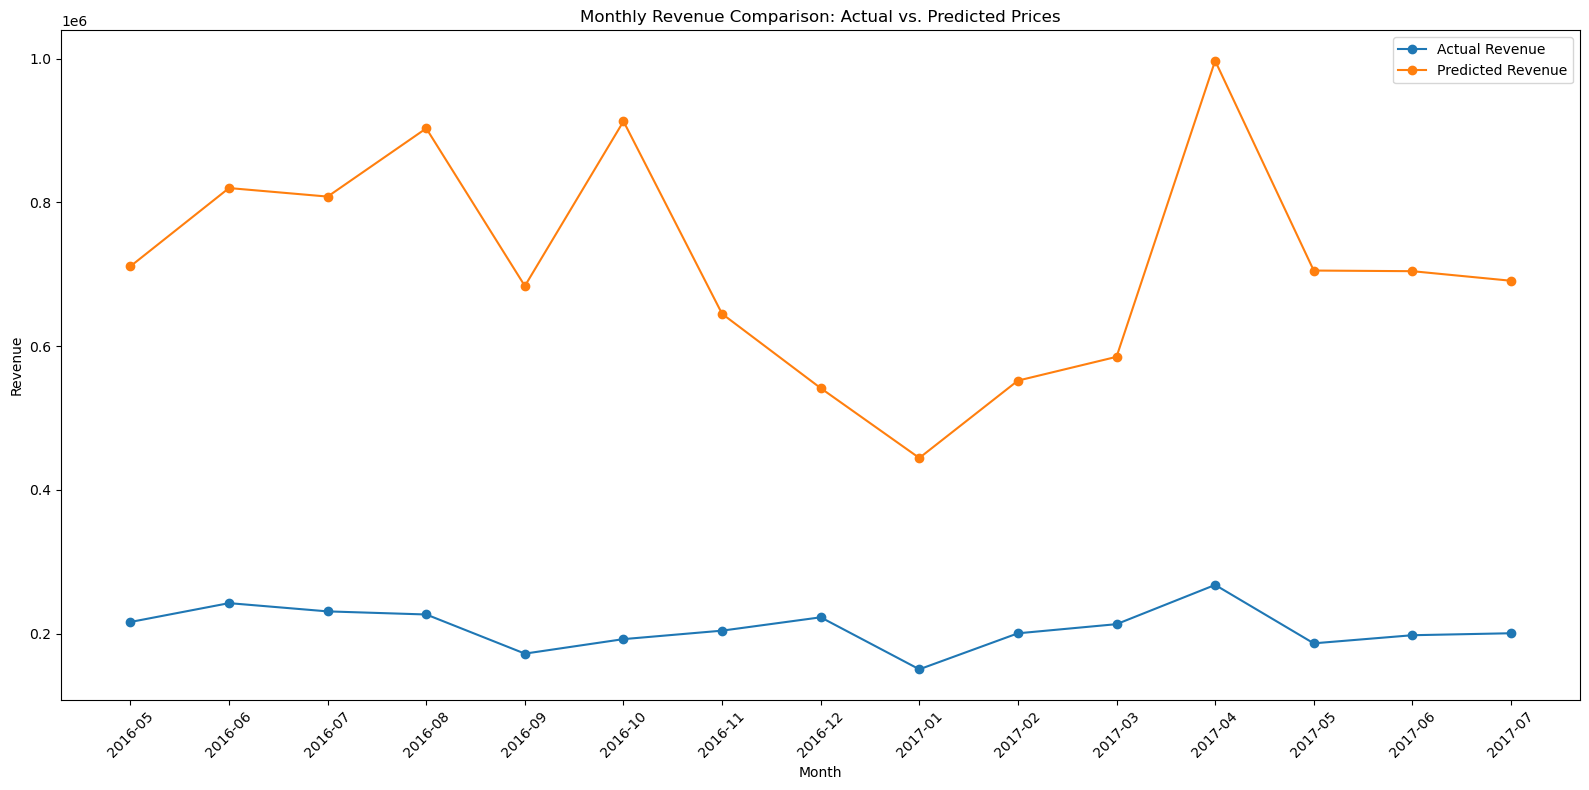

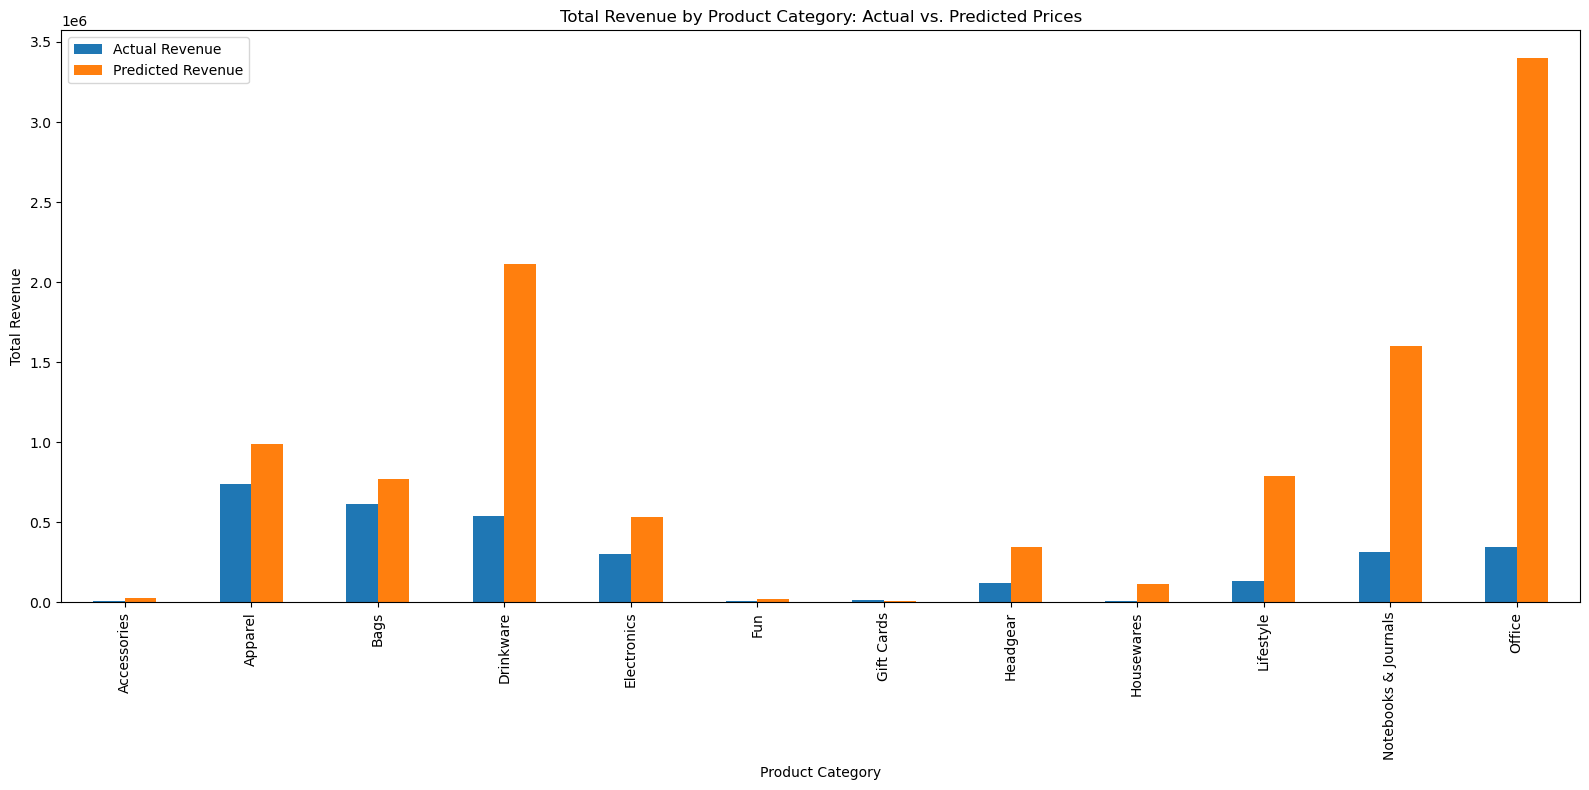

In [33]:
# Save the monthly revenue comparison plot
plt.figure(figsize=(16, 8))  # Increased the figure size
plt.plot(monthly_revenue['month'], monthly_revenue['actual_revenue'], label='Actual Revenue', marker='o')
plt.plot(monthly_revenue['month'], monthly_revenue['predicted_revenue'], label='Predicted Revenue', marker='o')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue Comparison: Actual vs. Predicted Prices')
plt.legend()
plt.tight_layout()  # Ensure nothing is cut off
plt.savefig("monthly_revenue_comparison.png")
plt.show()


# Save the category revenue comparison plot
category_revenue.plot(x='product_category', kind='bar', stacked=False, figsize=(16, 8))  # Increased the figure size
plt.xlabel('Product Category')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Product Category: Actual vs. Predicted Prices')
plt.legend(['Actual Revenue', 'Predicted Revenue'])
plt.tight_layout()  # Ensure nothing is cut off
plt.savefig("category_revenue_comparison.png")
plt.show()


It can be seen that with the new pricing model, revenue has significantly increased, especially among drinkware, Notebooks & Journals and Office products. 

However, there is a caveat that the data was trained on competitive Amazon data whose product categories do not align perfectly with that of Google data. The time period of the Amazon data and products do not match those of the Google data. Also, Amazon products were generally much higher priced than Google products. This difference in price may be a result of the product category mapping of Amazon products. Nonetheless, this may have led the model to believe that raising the price of Google products would be a good solution to raise revenue and compete with Amazon products' high prices. With competitive Amazon data that better matches that of Google's data, the model will be even more accurate.

Regardless, this dynamic price model can be used to grant insights into how each product category should be priced in order to increase revenue.